In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import pytorch_lightning as pl

import sklearn
import functools
import operator

import sys

import optuna

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import lat_dataset_load_new_lightning
#import struct_torch_net_class_lightning
import custom_torch_net_class_lightning

import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [3]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [4]:
pickle_file = open("study.pickle", "rb")
study = pickle.load(pickle_file)
study.best_params

{'lr': 8.26508087293339e-05, 'bs': 16}

In [5]:
study.best_trial

FrozenTrial(number=13, value=5.618940690510499e-07, datetime_start=datetime.datetime(2020, 6, 1, 0, 39, 57, 816978), datetime_complete=datetime.datetime(2020, 6, 1, 1, 3, 0, 881130), params={'lr': 8.26508087293339e-05, 'bs': 16}, distributions={'lr': LogUniformDistribution(high=0.0001, low=1e-07), 'bs': CategoricalDistribution(choices=(16, 32, 64, 128))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.040456730872392654, 1: 0.02319682575762272, 2: 0.011280376464128494, 3: 0.004097307566553354, 4: 0.001124523812904954, 5: 0.000464783952338621, 6: 0.00031903485069051385, 7: 0.0002300420601386577, 8: 0.00017536774976179004, 9: 0.0001359724410576746, 10: 0.00012116153084207326, 11: 0.00010295883839717135, 12: 8.287100354209542e-05, 13: 7.70455299061723e-05, 14: 5.8144007198279724e-05, 15: 5.0760048907250166e-05, 16: 4.2363200918771327e-05, 17: 3.769999966607429e-05, 18: 3.4139618946937844e-05, 19: 3.175929668941535e-05, 20: 2.8828817448811606e-05, 21: 2.795845466607716e-05, 22: 

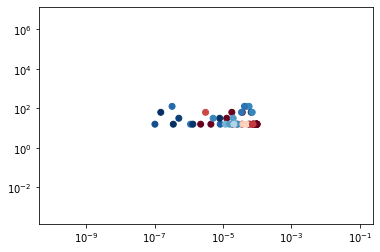

In [6]:
trial_coords = np.zeros((len(study.trials),2))

trial_metrics = np.zeros((len(study.trials)))

for trial_i, trial in enumerate(study.trials):
    par_i = 0
    for par_name in trial.params:
        trial_coords[trial_i, par_i] = trial.params[par_name]
        trial_metrics[trial_i] = trial.value
        par_i +=1

#fig, ax = plt.figure()
#ax.scatter(trial_coords[:,0], trial_coords[:,1], c=trial_metrics, cmap="RdBu")

#ax.set_scale("log")
plt.xscale("log")
plt.yscale("log")
plt.scatter(trial_coords[:,0], trial_coords[:,1], c=trial_metrics, cmap="RdBu")

In [7]:
checkpoint_path = "pl_checkpoints/CustomNet-013-epoch=198-val_loss=5.49258E-07.ckpt"

In [8]:
#best_model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path,hyper_parameters)
best_model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path)

best_model.to(device)

best_model.configure_loss()

best_model.eval()

custom layer operation not defined, assuming previous layer_size for
<class 'torch.nn.modules.activation.ReLU'>
custom layer operation not defined, assuming previous layer_size for
<class 'torch.nn.modules.activation.ReLU'>
custom layer operation not defined, assuming previous layer_size for
<class 'torch.nn.modules.activation.ReLU'>
custom layer operation not defined, assuming previous layer_size for
<class 'torch.nn.modules.activation.ReLU'>
custom layer operation not defined, assuming previous layer_size for
<class 'misc_modules.Mean'>


CustomNet(
  (cnn): Net(
    (layers): ModuleList(
      (0): AsymmetricCircularPadding()
      (1): Conv2d(4, 8, kernel_size=[2, 2], stride=[1, 1])
      (2): ReLU()
      (3): AsymmetricCircularPadding()
      (4): Conv2d(8, 8, kernel_size=[1, 1], stride=[1, 1])
      (5): ReLU()
      (6): AsymmetricCircularPadding()
      (7): Conv2d(8, 16, kernel_size=[2, 2], stride=[1, 1])
      (8): ReLU()
      (9): AsymmetricCircularPadding()
      (10): Conv2d(16, 16, kernel_size=[1, 1], stride=[1, 1])
      (11): ReLU()
      (12): AdaptiveAvgPool2d(output_size=[1, 1])
    )
  )
  (dense1): Net(
    (layers): ModuleList(
      (0): Reshape()
      (1): Mean()
    )
  )
  (loss): MSELoss()
)

In [9]:
"""
Load different lattice size
"""
#conf_file_dir = "/media/data/sbulusu/datasets/kl_config/"
conf_file_dir = "/media/data/sbulusu/datasets/complexworm/Results for CNN/"
#file_format = "*.dat"
#file_format_list = ["*1.170*.dat", "*0.910*.dat"]
file_format_list = ["configs-200-10*.dat"]
#file_format_list = ["configs-100-5*.dat"]
#file_format_list = ["configs*0.dat"]
#lat_size = [5,100]
lat_size = [10,200]
dim = len(lat_size)
conf_size = np.concatenate(([2],[dim],lat_size))
print(conf_size)
output_size = np.concatenate(([np.prod(conf_size[0:2])],conf_size[2:]))
print(output_size)

label_names = ["n", "phi2"]
labels_in_file_name = ["mu", "phase"]

new_dataset = lat_dataset_load_new_lightning.kl_dataset(conf_file_dir, file_format_list, conf_size, output_size, label_names, labels_in_file_name, transform=None, device=device)

[  2   2  10 200]
[  4  10 200]
[ -1   2   2  10 200]


Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.945.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)


first example loaded:
{'conf': tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 1,  0,  0,  ...,  0,  1,  1],
          [ 0,  0,  1,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  1,  0,  ...,  0, -1,  0],
          [ 0,  1, -1,  ...,  0, -1,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  1,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  1,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  1,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  1]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  1, 


Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.970.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.975.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.950.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.915.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.995.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.010.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.935.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.930.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.015.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.045.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.035.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.965.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.005.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.985.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.955.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.030.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.940.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.960.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.025.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.040.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.980.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.910.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.990.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-0.920.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.050.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.020.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-200-10-4.010-1.000-1.000.dat with size :torch.Size([5000, 2, 2, 10, 200])
skipping 0.3 of configurations (warm up)




last example loaded:
{'conf': tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  1,  1,  1],
          ...,
          [ 0,  1,  1,  ...,  0,  0,  0],
          [ 1,  0,  0,  ...,  1,  1,  1],
          [ 1,  1,  1,  ...,  0,  0,  0]],

         [[-1,  0,  0,  ...,  0,  0,  0],
          [-1,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0, -1,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ..., -1,  0,  0],
          [-1,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,

In [10]:
target_attributes = ["phi2", "n"]
output_attributes = target_attributes

new_dataset.train_label_names = target_attributes

In [11]:
net = best_model

In [12]:

new_data_len = len(new_dataset)
test_indices = list(range(new_data_len))

mus = np.zeros(new_data_len)

#input_size = net.input_size
input_size = new_dataset.output_size
output_size = net.output_size
model_input_shape = tuple(np.concatenate(([-1],input_size)))
print(model_input_shape)

#net_outputs = np.zeros( (len(test_indices)) )
net_outputs = np.zeros( (len(test_indices), len(output_attributes)) )
#labels = np.zeros( (len(test_indices)) )
labels = np.zeros( (len(test_indices), len(output_attributes)) )
mus = np.zeros( (len(test_indices)) )

for i in tqdm(range(new_data_len)):
#for i in tqdm(range(len(val_indices))):
    test_index = i
    conf_lat_links, label = new_dataset.get_conf(test_index)
    mus[i] = new_dataset.data[test_index]["mu"].detach().cpu().numpy()
    net_outputs[i] = net(conf_lat_links.view(model_input_shape).to(device).float()).detach().cpu().numpy()
    #net_outputs[i] = net(conf_lat_links.to(device).float()).detach().cpu().numpy()
    #output = net(conf_lat_links.view(model_input_shape).float())
    #labels[i] = label.detach().cpu().numpy()
    labels[i] = np.array(label)

(-1, 4, 10, 200)


In [13]:
print(f"lat_size {lat_size}")
for i in range(len(target_attributes)):
    print(f"MSE {target_attributes[i]}")
    print(np.mean( abs((labels[:,i]-net_outputs[:,i])**2) ))

lat_size [10, 200]
MSE phi2
1.1019778055492897e-05
MSE n
0.0006063485662877765


In [14]:
unique_mus = np.unique(mus)
num_mus = len(unique_mus)

In [15]:
##save the observable values in a dictionary
obs_mu_dict = {}
for target_name in target_attributes:
    obs_mu_dict[target_name] = {"label" : [],"pred" : []}

In [16]:

obs_label = []
obs_pred = []
for mu_val in unique_mus:
    mu_loc = np.where(mus == mu_val)[0]
    obs_label_mu = np.array(labels[mu_loc,0])
    obs_pred_mu = np.array(net_outputs[mu_loc,0])
    
    obs_label.append(obs_label_mu)    
    obs_pred.append(obs_pred_mu)

    

In [17]:
##to be able to plot the observables against mu, they have to be sorted with respect to it
for mu_val in unique_mus:
    ##find which examples have a particular mu value (mu_val)
    mu_loc = np.where(mus == mu_val)[0]
    ##find the labels and prediction of observables which correspond to these examples
    obs_label_mu_val = labels[mu_loc]
    obs_pred_mu_val = net_outputs[mu_loc]
    for target_i, target_name in enumerate(target_attributes):
        
        obs_label_mu = np.array(labels[mu_loc,target_i])
        obs_pred_mu = np.array(net_outputs[mu_loc,target_i])
        
        obs_mu_dict[target_name]["label"].append(obs_label_mu)
        obs_mu_dict[target_name]["pred"].append(obs_pred_mu)

        
        
        
for target_i, target_name in enumerate(target_attributes):
    obs_mu_dict[target_name]["label"] = np.array(obs_mu_dict[target_name]["label"])
    obs_mu_dict[target_name]["pred"] = np.array(obs_mu_dict[target_name]["pred"])

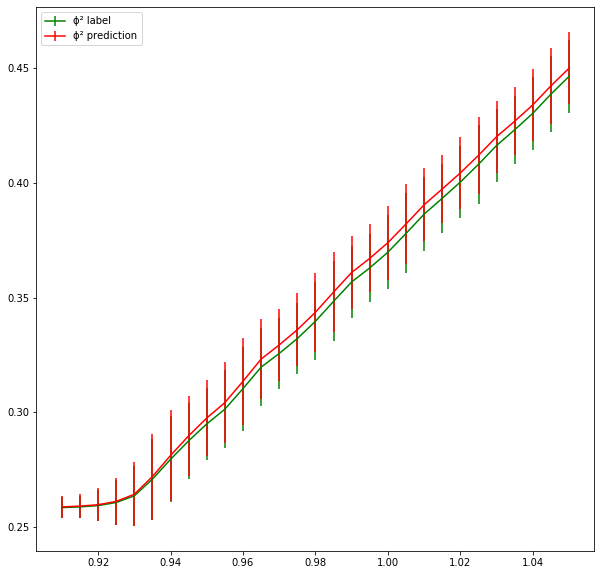

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]

plot_target = "phi2"

obs_label = np.array(obs_mu_dict[plot_target]["label"])
obs_pred = np.array(obs_mu_dict[plot_target]["pred"])

mean_obs_label = np.zeros(len(obs_label))
std_obs_label = np.zeros(len(obs_label))

mean_obs_pred = np.zeros(len(obs_pred))
std_obs_pred = np.zeros(len(obs_pred)) 

for i in range(len(obs_label)):
    mean_obs_label[i] = np.mean(obs_label[i])
    std_obs_label[i] = np.std(obs_label[i])
    
    mean_obs_pred[i] = np.mean(obs_pred[i])
    std_obs_pred[i] = np.std(obs_pred[i])
    
#plt.scatter(unique_mus, mean_obs_label, c="g")
#plt.scatter(unique_mus, mean_obs_pred, c="r")
    
plt.errorbar(unique_mus, mean_obs_label, yerr=std_obs_label, color="g", label="ϕ² label")
plt.errorbar(unique_mus, mean_obs_pred, yerr=std_obs_pred, color="r", label="ϕ² prediction")
plt.legend(loc="upper left")
plt.savefig("phi2_mu_mod" + str(lat_size))

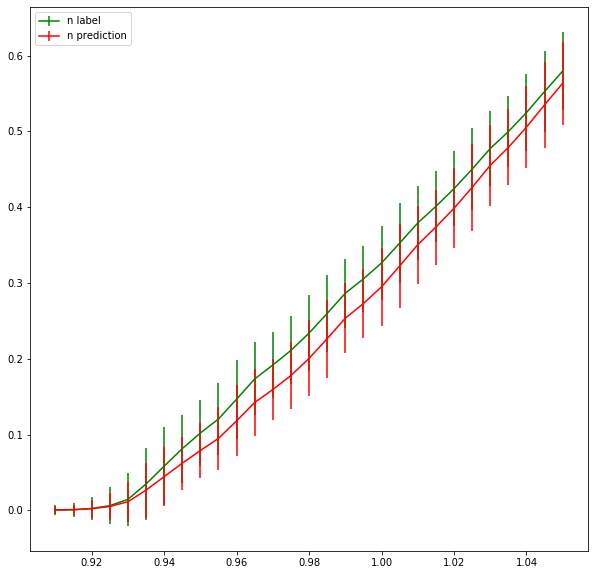

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]

plot_target = "n"

obs_label = np.array(obs_mu_dict[plot_target]["label"])
obs_pred = np.array(obs_mu_dict[plot_target]["pred"])

mean_obs_label = np.zeros(len(obs_label))
std_obs_label = np.zeros(len(obs_label))

mean_obs_pred = np.zeros(len(obs_pred))
std_obs_pred = np.zeros(len(obs_pred)) 

for i in range(len(obs_label)):
    mean_obs_label[i] = np.mean(obs_label[i])
    std_obs_label[i] = np.std(obs_label[i])
    
    mean_obs_pred[i] = np.mean(obs_pred[i])
    std_obs_pred[i] = np.std(obs_pred[i])
    
#plt.scatter(unique_mus, mean_obs_label, c="g")
#plt.scatter(unique_mus, mean_obs_pred, c="r")
    
plt.errorbar(unique_mus, mean_obs_label, yerr=std_obs_label, color="g", label="n label")
plt.errorbar(unique_mus, mean_obs_pred, yerr=std_obs_pred, color="r", label="n prediction")
plt.legend(loc="upper left")
plt.savefig("n_mu_mod" + str(lat_size))

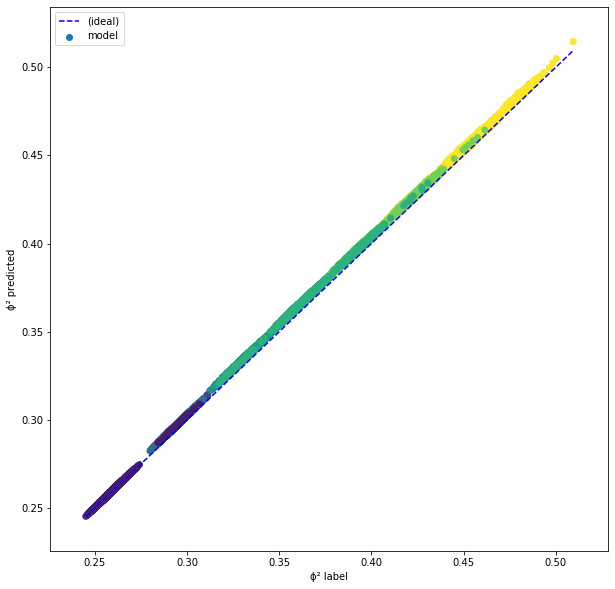

In [20]:
plt.rcParams['figure.figsize'] = [10, 10]

target_i = 0

x_max = np.max(labels[:,target_i])
x_min = np.min(labels[:,target_i])


#plt.scatter(labels[:,target_i], net_outputs[:,target_i], c="r", label="model")
plt.scatter(labels[:,target_i], net_outputs[:,target_i], c=mus, label="model")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.xlabel("ϕ² label")
plt.ylabel("ϕ² predicted")
plt.legend(loc="upper left")
#plt.show()
plt.savefig("phi2_label_pred_mod" + str(lat_size)) 

In [21]:
len(unique_mus)

29

In [22]:
"""
plt.rcParams['figure.figsize'] = [30, 5]

target_i = 0

plot_unique_mus = unique_mus[::3]

fig, ax = plt.subplots(ncols=len(plot_unique_mus))

target_labels = labels[:,target_i]
target_net_outputs = net_outputs[:,target_i]



#for mu_i, mu_val in enumerate(unique_mus[::10]):
for mu_i, mu_val in enumerate(plot_unique_mus):
    
    plot_indices = np.argwhere(unique_mus == mu_val)

    plot_target_labels = target_labels[plot_indices]
    plot_target_net_outputs = target_net_outputs[plot_indices]
    
    ax[mu_i].scatter(plot_target_labels, plot_target_net_outputs)
    ax[mu_i].plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
"""

'\nplt.rcParams[\'figure.figsize\'] = [30, 5]\n\ntarget_i = 0\n\nplot_unique_mus = unique_mus[::3]\n\nfig, ax = plt.subplots(ncols=len(plot_unique_mus))\n\ntarget_labels = labels[:,target_i]\ntarget_net_outputs = net_outputs[:,target_i]\n\n\n\n#for mu_i, mu_val in enumerate(unique_mus[::10]):\nfor mu_i, mu_val in enumerate(plot_unique_mus):\n    \n    plot_indices = np.argwhere(unique_mus == mu_val)\n\n    plot_target_labels = target_labels[plot_indices]\n    plot_target_net_outputs = target_net_outputs[plot_indices]\n    \n    ax[mu_i].scatter(plot_target_labels, plot_target_net_outputs)\n    ax[mu_i].plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")\n'

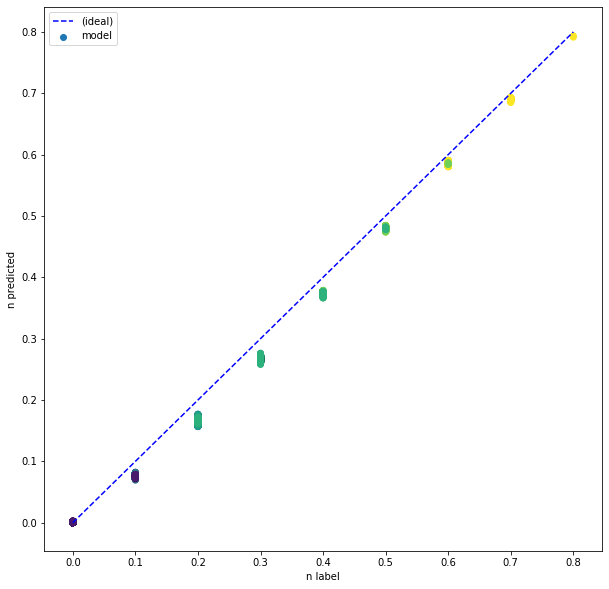

In [23]:
plt.rcParams['figure.figsize'] = [10, 10]

target_i = 1

x_max = np.max(labels[:,target_i])
x_min = np.min(labels[:,target_i])


#plt.scatter(labels[:,target_i], net_outputs[:,target_i], c="r", label="model")
plt.scatter(labels[:,target_i], net_outputs[:,target_i], c=mus, label="model")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.xlabel("n label")
plt.ylabel("n predicted")
plt.legend(loc="upper left")
#plt.show()
plt.savefig("n_label_pred_mod" + str(lat_size)) 

In [24]:
"""
Load different lattice size
"""
#conf_file_dir = "/media/data/sbulusu/datasets/kl_config/"
conf_file_dir = "/media/data/sbulusu/datasets/complexworm/Results for CNN/"
#file_format = "*.dat"
#file_format_list = ["*1.170*.dat", "*0.910*.dat"]
#file_format_list = ["configs-200-10*.dat"]
file_format_list = ["configs-100-5*.dat"]
#file_format_list = ["configs-50-2*.dat"]
#file_format_list = ["configs*0.dat"]
#lat_size = [10,200]
lat_size = [5,100]
#lat_size = [2,50]
dim = len(lat_size)
conf_size = np.concatenate(([2],[dim],lat_size))
print(conf_size)
output_size = np.concatenate(([np.prod(conf_size[0:2])],conf_size[2:]))
print(output_size)

label_names = ["n", "phi2"]
labels_in_file_name = ["mu", "phase"]

new_dataset = lat_dataset_load_new_lightning.kl_dataset(conf_file_dir, file_format_list, conf_size, output_size, label_names, labels_in_file_name, transform=None, device=device)

[  2   2   5 100]
[  4   5 100]
[ -1   2   2   5 100]


Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.050.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)


first example loaded:
{'conf': tensor([[[[ 1,  0,  0,  ...,  0,  2,  1],
          [ 0,  1,  0,  ...,  2,  0,  0],
          [ 2,  1,  3,  ...,  1,  1,  2],
          [ 0,  0, -1,  ...,  1,  0,  1],
          [ 1,  2,  2,  ...,  0,  1,  0]],

         [[ 0,  0,  0,  ...,  1, -2,  1],
          [ 0, -1,  1,  ...,  0,  0,  1],
          [ 0,  0, -1,  ...,  0,  0,  0],
          [ 1,  0,  0,  ...,  0,  1, -1],
          [ 0, -1,  0,  ...,  0,  0,  0]]],


        [[[ 0,  1,  0,  ...,  0,  0,  0],
          [ 0,  0,  1,  ...,  0,  1,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  0,  0],
          [ 1,  0,  1,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]]]), 'mu': tensor(1.0500), 'phase': tensor(1.), 'n': tensor(0.8000, dtype=torch.float64), 'phi2': tensor(0.4983, dtype=tor


Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.955.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.990.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.970.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.045.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.005.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.980.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.040.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.030.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.015.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.940.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.010.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.000.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.915.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.025.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.950.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.930.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.960.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.925.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.995.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.020.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.985.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.910.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-1.035.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.945.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.965.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.935.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-100-5-4.010-1.000-0.920.dat with size :torch.Size([5000, 2, 2, 5, 100])
skipping 0.3 of configurations (warm up)




last example loaded:
{'conf': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]]), 'mu': tensor(0.9200), 'phase': tensor(0.), 'n': tensor(0., dtype=torch.float64), 'phi2': tensor(0.2521, dtype=torch.float64), 'id': 101499}


In [25]:
target_attributes = ["phi2", "n"]
output_attributes = target_attributes

new_dataset.train_label_names = target_attributes

In [26]:
net = best_model

In [27]:

new_data_len = len(new_dataset)
test_indices = list(range(new_data_len))

mus = np.zeros(new_data_len)

#input_size = net.input_size
input_size = new_dataset.output_size
output_size = net.output_size
model_input_shape = tuple(np.concatenate(([-1],input_size)))
print(model_input_shape)

#net_outputs = np.zeros( (len(test_indices)) )
net_outputs = np.zeros( (len(test_indices), len(output_attributes)) )
#labels = np.zeros( (len(test_indices)) )
labels = np.zeros( (len(test_indices), len(output_attributes)) )
mus = np.zeros( (len(test_indices)) )

for i in tqdm(range(new_data_len)):
#for i in tqdm(range(len(val_indices))):
    test_index = i
    conf_lat_links, label = new_dataset.get_conf(test_index)
    mus[i] = new_dataset.data[test_index]["mu"].detach().cpu().numpy()
    net_outputs[i] = net(conf_lat_links.view(model_input_shape).to(device).float()).detach().cpu().numpy()
    #net_outputs[i] = net(conf_lat_links.to(device).float()).detach().cpu().numpy()
    #output = net(conf_lat_links.view(model_input_shape).float())
    #labels[i] = label.detach().cpu().numpy()
    labels[i] = np.array(label)

(-1, 4, 5, 100)


In [28]:
print(f"lat_size {lat_size}")
for i in range(len(target_attributes)):
    print(f"MSE {target_attributes[i]}")
    print(np.mean( abs((labels[:,i]-net_outputs[:,i])**2) ))

lat_size [5, 100]
MSE phi2
1.545544002629478e-05
MSE n
0.0009964265284393206


In [29]:
unique_mus = np.unique(mus)
num_mus = len(unique_mus)

In [30]:
##save the observable values in a dictionary
obs_mu_dict = {}
for target_name in target_attributes:
    obs_mu_dict[target_name] = {"label" : [],"pred" : []}

In [31]:

obs_label = []
obs_pred = []
for mu_val in unique_mus:
    mu_loc = np.where(mus == mu_val)[0]
    obs_label_mu = np.array(labels[mu_loc,0])
    obs_pred_mu = np.array(net_outputs[mu_loc,0])
    
    obs_label.append(obs_label_mu)    
    obs_pred.append(obs_pred_mu)

    

In [32]:
##to be able to plot the observables against mu, they have to be sorted with respect to it
for mu_val in unique_mus:
    ##find which examples have a particular mu value (mu_val)
    mu_loc = np.where(mus == mu_val)[0]
    ##find the labels and prediction of observables which correspond to these examples
    obs_label_mu_val = labels[mu_loc]
    obs_pred_mu_val = net_outputs[mu_loc]
    for target_i, target_name in enumerate(target_attributes):
        
        obs_label_mu = np.array(labels[mu_loc,target_i])
        obs_pred_mu = np.array(net_outputs[mu_loc,target_i])
        
        obs_mu_dict[target_name]["label"].append(obs_label_mu)
        obs_mu_dict[target_name]["pred"].append(obs_pred_mu)

        
        
        
for target_i, target_name in enumerate(target_attributes):
    obs_mu_dict[target_name]["label"] = np.array(obs_mu_dict[target_name]["label"])
    obs_mu_dict[target_name]["pred"] = np.array(obs_mu_dict[target_name]["pred"])

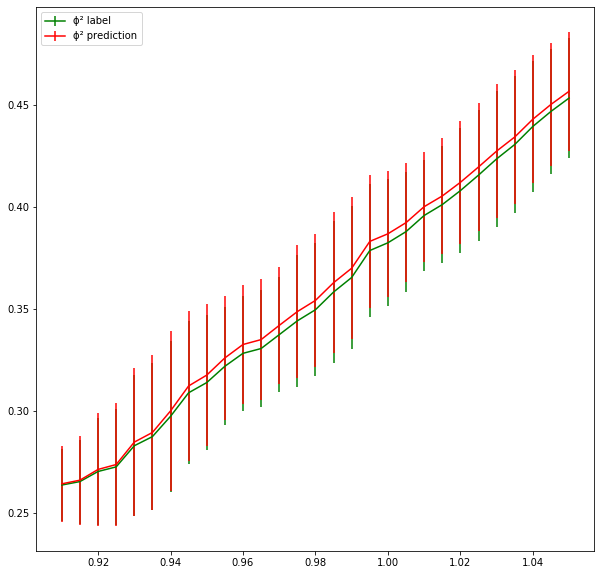

In [33]:
plt.rcParams['figure.figsize'] = [10, 10]

plot_target = "phi2"

obs_label = np.array(obs_mu_dict[plot_target]["label"])
obs_pred = np.array(obs_mu_dict[plot_target]["pred"])

mean_obs_label = np.zeros(len(obs_label))
std_obs_label = np.zeros(len(obs_label))

mean_obs_pred = np.zeros(len(obs_pred))
std_obs_pred = np.zeros(len(obs_pred)) 

for i in range(len(obs_label)):
    mean_obs_label[i] = np.mean(obs_label[i])
    std_obs_label[i] = np.std(obs_label[i])
    
    mean_obs_pred[i] = np.mean(obs_pred[i])
    std_obs_pred[i] = np.std(obs_pred[i])
    
#plt.scatter(unique_mus, mean_obs_label, c="g")
#plt.scatter(unique_mus, mean_obs_pred, c="r")
    
plt.errorbar(unique_mus, mean_obs_label, yerr=std_obs_label, color="g", label="ϕ² label")
plt.errorbar(unique_mus, mean_obs_pred, yerr=std_obs_pred, color="r", label="ϕ² prediction")
plt.legend(loc="upper left")
plt.savefig("phi2_mu_mod" + str(lat_size))

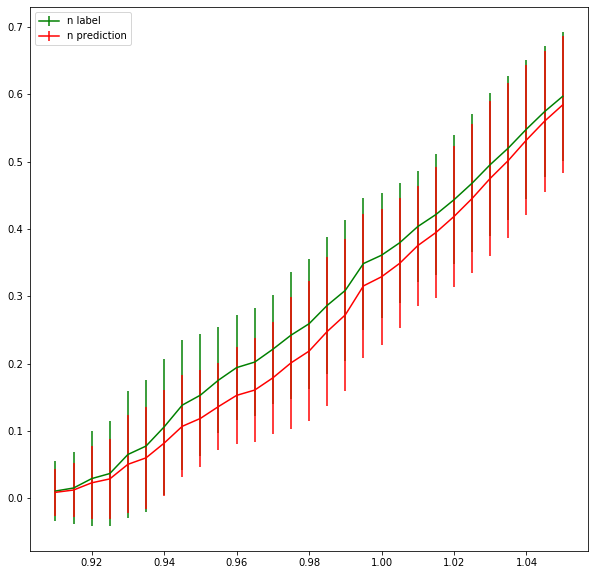

In [34]:
plt.rcParams['figure.figsize'] = [10, 10]

plot_target = "n"

obs_label = np.array(obs_mu_dict[plot_target]["label"])
obs_pred = np.array(obs_mu_dict[plot_target]["pred"])

mean_obs_label = np.zeros(len(obs_label))
std_obs_label = np.zeros(len(obs_label))

mean_obs_pred = np.zeros(len(obs_pred))
std_obs_pred = np.zeros(len(obs_pred)) 

for i in range(len(obs_label)):
    mean_obs_label[i] = np.mean(obs_label[i])
    std_obs_label[i] = np.std(obs_label[i])
    
    mean_obs_pred[i] = np.mean(obs_pred[i])
    std_obs_pred[i] = np.std(obs_pred[i])
    
#plt.scatter(unique_mus, mean_obs_label, c="g")
#plt.scatter(unique_mus, mean_obs_pred, c="r")
    
plt.errorbar(unique_mus, mean_obs_label, yerr=std_obs_label, color="g", label="n label")
plt.errorbar(unique_mus, mean_obs_pred, yerr=std_obs_pred, color="r", label="n prediction")
plt.legend(loc="upper left")
plt.savefig("n_mu_mod" + str(lat_size))

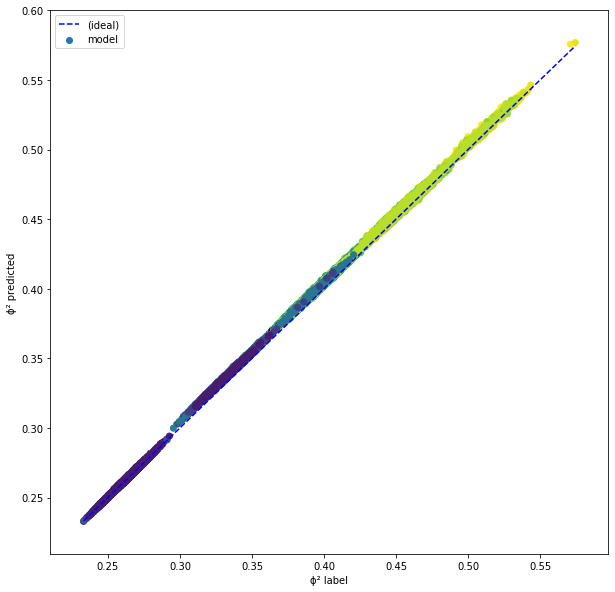

In [35]:
plt.rcParams['figure.figsize'] = [10, 10]

target_i = 0

x_max = np.max(labels[:,target_i])
x_min = np.min(labels[:,target_i])


#plt.scatter(labels[:,target_i], net_outputs[:,target_i], c="r", label="model")
plt.scatter(labels[:,target_i], net_outputs[:,target_i], c=mus, label="model")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.xlabel("ϕ² label")
plt.ylabel("ϕ² predicted")
plt.legend(loc="upper left")
#plt.show()
plt.savefig("phi2_label_pred_mod" + str(lat_size)) 

In [36]:
len(unique_mus)

29

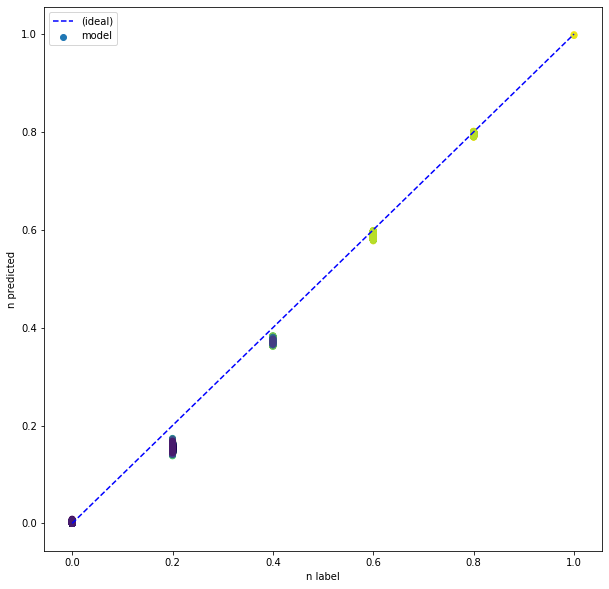

In [37]:
plt.rcParams['figure.figsize'] = [10, 10]

target_i = 1

x_max = np.max(labels[:,target_i])
x_min = np.min(labels[:,target_i])


#plt.scatter(labels[:,target_i], net_outputs[:,target_i], c="r", label="model")
plt.scatter(labels[:,target_i], net_outputs[:,target_i], c=mus, label="model")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.xlabel("n label")
plt.ylabel("n predicted")
plt.legend(loc="upper left")
#plt.show()
plt.savefig("n_label_pred_mod" + str(lat_size)) 

In [38]:
"""
Load different lattice size
"""
#conf_file_dir = "/media/data/sbulusu/datasets/kl_config/"
conf_file_dir = "/media/data/sbulusu/datasets/complexworm/Results for CNN/"
#file_format = "*.dat"
#file_format_list = ["*1.170*.dat", "*0.910*.dat"]
#file_format_list = ["configs-200-10*.dat"]
#file_format_list = ["configs-100-5*.dat"]
#file_format_list = ["configs-50-2*.dat"]
file_format_list = ["configs-125-8*.dat"]
#file_format_list = ["configs*0.dat"]
#lat_size = [10,200]
#lat_size = [2,50]
lat_size = [8,125]
dim = len(lat_size)
conf_size = np.concatenate(([2],[dim],lat_size))
print(conf_size)
output_size = np.concatenate(([np.prod(conf_size[0:2])],conf_size[2:]))
print(output_size)

label_names = ["n", "phi2"]
labels_in_file_name = ["mu", "phase"]

new_dataset = lat_dataset_load_new_lightning.kl_dataset(conf_file_dir, file_format_list, conf_size, output_size, label_names, labels_in_file_name, transform=None, device=device)

[  2   2   8 125]
[  4   8 125]
[ -1   2   2   8 125]


Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.025.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)


first example loaded:
{'conf': tensor([[[[ 0,  1,  2,  ...,  0,  1,  1],
          [ 0,  2,  1,  ...,  1,  0,  0],
          [ 1,  0,  1,  ...,  1,  1,  1],
          ...,
          [ 0,  0,  0,  ...,  0,  1,  1],
          [ 1,  1,  0,  ...,  0,  1,  1],
          [ 2,  0,  0,  ...,  1,  0,  0]],

         [[ 0,  1,  0,  ...,  1, -1,  0],
          [ 0, -1,  1,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 1,  0,  0,  ...,  0,  0,  0],
          [ 1,  0,  1,  ...,  1, -1,  0],
          [-1,  2,  1,  ...,  1,  0,  0]]],


        [[[ 1,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  1,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  1,  2,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  1,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0, 


Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.935.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.950.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.965.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.940.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.970.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.995.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.010.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.040.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.960.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.915.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.990.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.030.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.005.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.975.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.000.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.910.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.045.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.020.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.980.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.985.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.955.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.930.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.920.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.945.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-0.925.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.050.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)



Read conf file /media/data/sbulusu/datasets/complexworm/Results for CNN/configs-125-8-4.010-1.000-1.035.dat with size :torch.Size([5000, 2, 2, 8, 125])
skipping 0.3 of configurations (warm up)




last example loaded:
{'conf': tensor([[[[ 0,  0,  1,  ...,  0,  0,  1],
          [ 1,  1,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  1,  1,  0],
          ...,
          [ 1,  2,  1,  ...,  0,  1,  1],
          [ 1,  1,  0,  ...,  2,  1,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0, -1,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0, -1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0, -1,  ...,  0, -1,  0],
          [-1,  0,  0,  ...,  0,  0,  1],
          [-1,  0,  0,  ...,  0,  0,  1]]],


        [[[ 0,  1,  0,  ...,  1,  0,  0],
          [ 0,  0,  1,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  1,  0],
          ...,
          [ 0,  1,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  1,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],

         [[ 0,  0,  0,  ...,  0,  1,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  1,  0,  0],
          ...,
          [ 1,  0,

In [39]:
target_attributes = ["phi2", "n"]
output_attributes = target_attributes

new_dataset.train_label_names = target_attributes

In [40]:
net = best_model

In [41]:

new_data_len = len(new_dataset)
test_indices = list(range(new_data_len))

mus = np.zeros(new_data_len)

#input_size = net.input_size
input_size = new_dataset.output_size
output_size = net.output_size
model_input_shape = tuple(np.concatenate(([-1],input_size)))
print(model_input_shape)

#net_outputs = np.zeros( (len(test_indices)) )
net_outputs = np.zeros( (len(test_indices), len(output_attributes)) )
#labels = np.zeros( (len(test_indices)) )
labels = np.zeros( (len(test_indices), len(output_attributes)) )
mus = np.zeros( (len(test_indices)) )

for i in tqdm(range(new_data_len)):
#for i in tqdm(range(len(val_indices))):
    test_index = i
    conf_lat_links, label = new_dataset.get_conf(test_index)
    mus[i] = new_dataset.data[test_index]["mu"].detach().cpu().numpy()
    net_outputs[i] = net(conf_lat_links.view(model_input_shape).to(device).float()).detach().cpu().numpy()
    #net_outputs[i] = net(conf_lat_links.to(device).float()).detach().cpu().numpy()
    #output = net(conf_lat_links.view(model_input_shape).float())
    #labels[i] = label.detach().cpu().numpy()
    labels[i] = np.array(label)

(-1, 4, 8, 125)


In [42]:
print(f"lat_size {lat_size}")
for i in range(len(target_attributes)):
    print(f"MSE {target_attributes[i]}")
    print(np.mean( abs((labels[:,i]-net_outputs[:,i])**2) ))

lat_size [8, 125]
MSE phi2
1.1932064498784872e-05
MSE n
0.0006717790127903367


In [43]:
unique_mus = np.unique(mus)
num_mus = len(unique_mus)

In [44]:
##save the observable values in a dictionary
obs_mu_dict = {}
for target_name in target_attributes:
    obs_mu_dict[target_name] = {"label" : [],"pred" : []}

In [45]:

obs_label = []
obs_pred = []
for mu_val in unique_mus:
    mu_loc = np.where(mus == mu_val)[0]
    obs_label_mu = np.array(labels[mu_loc,0])
    obs_pred_mu = np.array(net_outputs[mu_loc,0])
    
    obs_label.append(obs_label_mu)    
    obs_pred.append(obs_pred_mu)

    

In [46]:
##to be able to plot the observables against mu, they have to be sorted with respect to it
for mu_val in unique_mus:
    ##find which examples have a particular mu value (mu_val)
    mu_loc = np.where(mus == mu_val)[0]
    ##find the labels and prediction of observables which correspond to these examples
    obs_label_mu_val = labels[mu_loc]
    obs_pred_mu_val = net_outputs[mu_loc]
    for target_i, target_name in enumerate(target_attributes):
        
        obs_label_mu = np.array(labels[mu_loc,target_i])
        obs_pred_mu = np.array(net_outputs[mu_loc,target_i])
        
        obs_mu_dict[target_name]["label"].append(obs_label_mu)
        obs_mu_dict[target_name]["pred"].append(obs_pred_mu)

        
        
        
for target_i, target_name in enumerate(target_attributes):
    obs_mu_dict[target_name]["label"] = np.array(obs_mu_dict[target_name]["label"])
    obs_mu_dict[target_name]["pred"] = np.array(obs_mu_dict[target_name]["pred"])

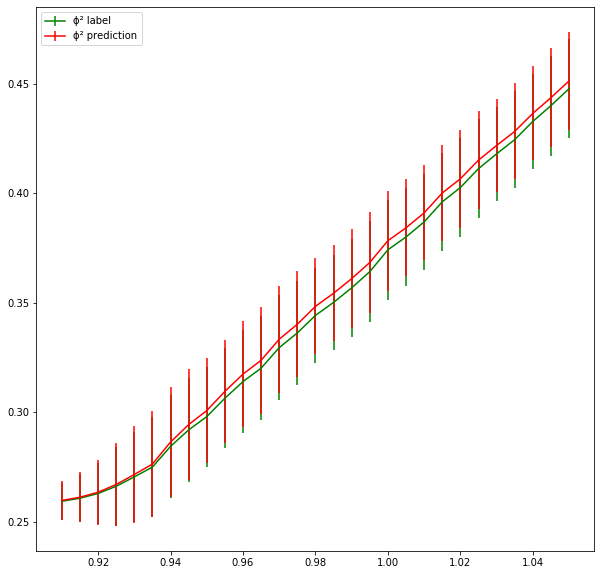

In [47]:
plt.rcParams['figure.figsize'] = [10, 10]

plot_target = "phi2"

obs_label = np.array(obs_mu_dict[plot_target]["label"])
obs_pred = np.array(obs_mu_dict[plot_target]["pred"])

mean_obs_label = np.zeros(len(obs_label))
std_obs_label = np.zeros(len(obs_label))

mean_obs_pred = np.zeros(len(obs_pred))
std_obs_pred = np.zeros(len(obs_pred)) 

for i in range(len(obs_label)):
    mean_obs_label[i] = np.mean(obs_label[i])
    std_obs_label[i] = np.std(obs_label[i])
    
    mean_obs_pred[i] = np.mean(obs_pred[i])
    std_obs_pred[i] = np.std(obs_pred[i])
    
#plt.scatter(unique_mus, mean_obs_label, c="g")
#plt.scatter(unique_mus, mean_obs_pred, c="r")
    
plt.errorbar(unique_mus, mean_obs_label, yerr=std_obs_label, color="g", label="ϕ² label")
plt.errorbar(unique_mus, mean_obs_pred, yerr=std_obs_pred, color="r", label="ϕ² prediction")
plt.legend(loc="upper left")
plt.savefig("phi2_mu_mod" + str(lat_size))

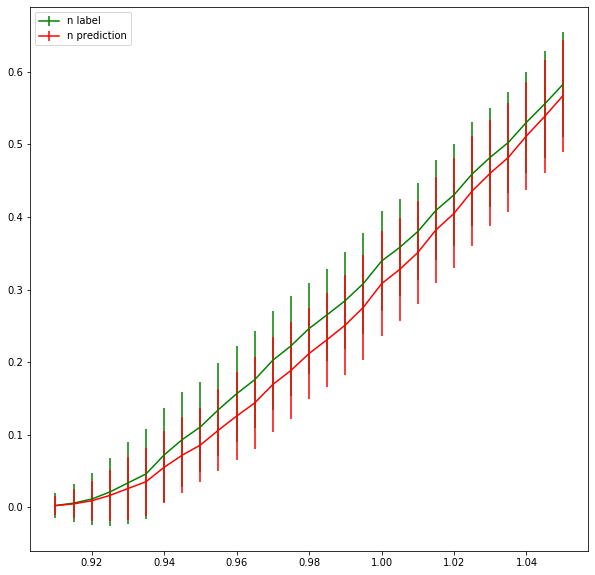

In [48]:
plt.rcParams['figure.figsize'] = [10, 10]

plot_target = "n"

obs_label = np.array(obs_mu_dict[plot_target]["label"])
obs_pred = np.array(obs_mu_dict[plot_target]["pred"])

mean_obs_label = np.zeros(len(obs_label))
std_obs_label = np.zeros(len(obs_label))

mean_obs_pred = np.zeros(len(obs_pred))
std_obs_pred = np.zeros(len(obs_pred)) 

for i in range(len(obs_label)):
    mean_obs_label[i] = np.mean(obs_label[i])
    std_obs_label[i] = np.std(obs_label[i])
    
    mean_obs_pred[i] = np.mean(obs_pred[i])
    std_obs_pred[i] = np.std(obs_pred[i])
    
#plt.scatter(unique_mus, mean_obs_label, c="g")
#plt.scatter(unique_mus, mean_obs_pred, c="r")
    
plt.errorbar(unique_mus, mean_obs_label, yerr=std_obs_label, color="g", label="n label")
plt.errorbar(unique_mus, mean_obs_pred, yerr=std_obs_pred, color="r", label="n prediction")
plt.legend(loc="upper left")
plt.savefig("n_mu_mod" + str(lat_size))

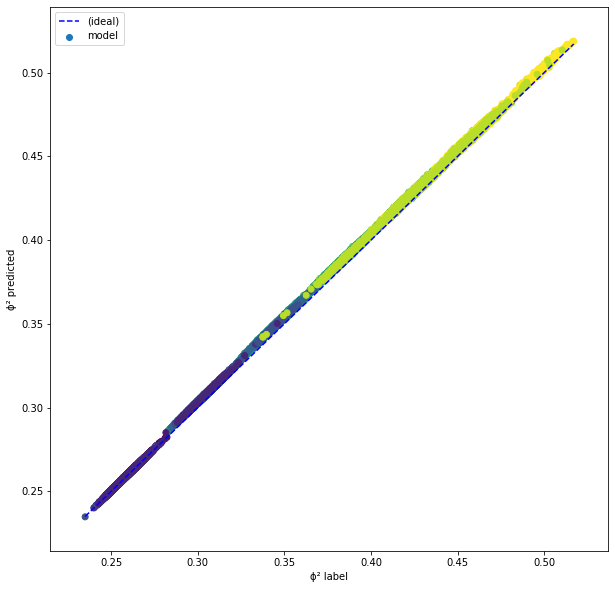

In [49]:
plt.rcParams['figure.figsize'] = [10, 10]

target_i = 0

x_max = np.max(labels[:,target_i])
x_min = np.min(labels[:,target_i])


#plt.scatter(labels[:,target_i], net_outputs[:,target_i], c="r", label="model")
plt.scatter(labels[:,target_i], net_outputs[:,target_i], c=mus, label="model")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.xlabel("ϕ² label")
plt.ylabel("ϕ² predicted")
plt.legend(loc="upper left")
#plt.show()
plt.savefig("phi2_label_pred_mod" + str(lat_size)) 

In [50]:
len(unique_mus)

29

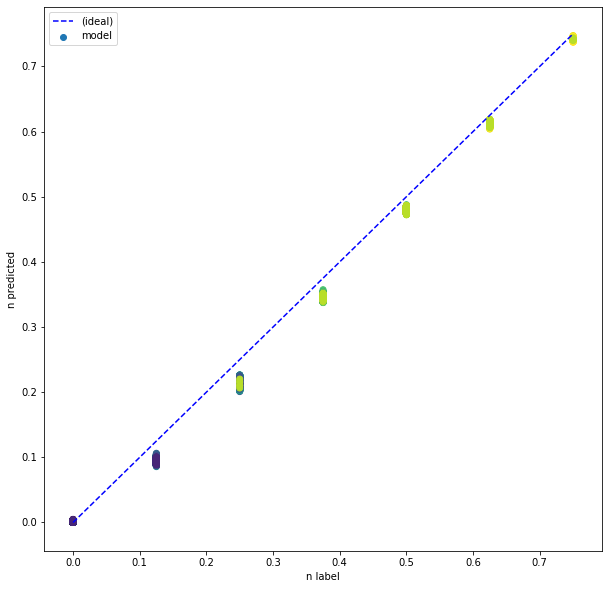

In [51]:
plt.rcParams['figure.figsize'] = [10, 10]

target_i = 1

x_max = np.max(labels[:,target_i])
x_min = np.min(labels[:,target_i])


#plt.scatter(labels[:,target_i], net_outputs[:,target_i], c="r", label="model")
plt.scatter(labels[:,target_i], net_outputs[:,target_i], c=mus, label="model")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.xlabel("n label")
plt.ylabel("n predicted")
plt.legend(loc="upper left")
#plt.show()
plt.savefig("n_label_pred_mod" + str(lat_size)) 

In [52]:
#conv = best_model.cnn.layers[1]
#conv.weight

In [53]:
#mlpconv = best_model.cnn.layers[4]
#mlpconv.weight

In [54]:
#[phi2, n]
test_lat_size = [2,2]

#kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
#kl_conf[:,1,0,:,:] = 0
kl_conf[:,0,0,:,:] = 0
input_conf = kl_conf.reshape(1,4,*test_lat_size)
best_model(input_conf)

tensor([[0.2082, 0.0000]], device='cuda:0', grad_fn=<MeanBackward1>)

In [55]:
W_obs_ratio = np.loadtxt("W_obs_ratio.txt")

output_phis = np.zeros(len(W_obs_ratio))
output_ns = np.zeros(len(W_obs_ratio))

for i in tqdm(range(len(W_obs_ratio))):
    
    #kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
    kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
    #kl_conf[:,1,0,:,:] = 0
    kl_conf[:,0,0,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    output = best_model(input_conf)
    #print(output)
    output_phis[i] = float(output[0][0])
    output_ns[i] = float(output[0][1])
    

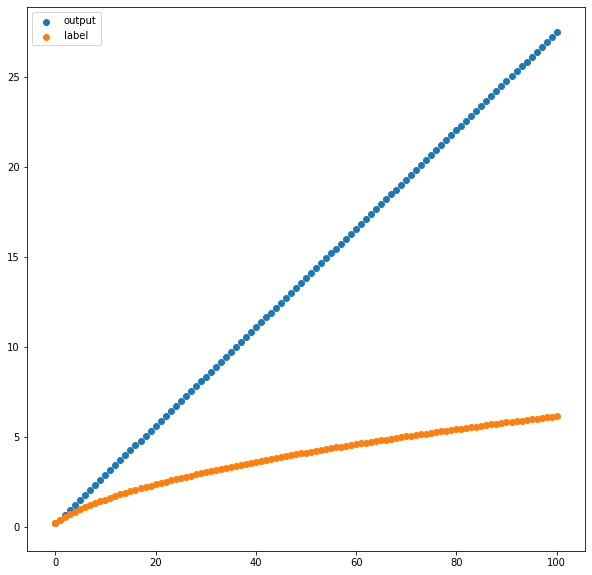

In [56]:
plt.scatter(range(len(W_obs_ratio)), output_phis, label="output")
plt.scatter(range(len(W_obs_ratio)), W_obs_ratio, label="label")
plt.legend(loc="upper left")

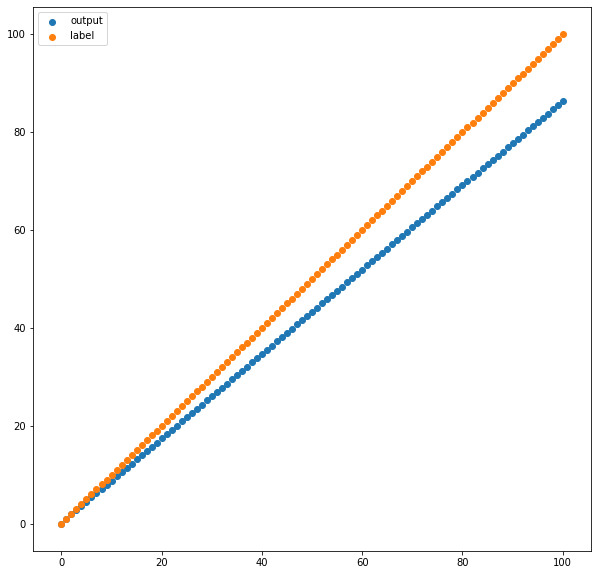

In [57]:
plt.scatter(range(len(W_obs_ratio)), output_ns, label="output")
plt.scatter(range(len(W_obs_ratio)), range(len(W_obs_ratio)), label="label")
plt.legend(loc="upper left")

In [58]:
def link_per_lat_point(links, lat_size, dims):

    #empty channels where the linsk on other directions should be saved
    empty_link_channels = np.zeros(links.shape)
    for d in range(dims):
        #print(d)
        #print(links)
        d_links = links[d]
        #print(d_links)
        perm_links = np.roll(d_links, shift=1, axis=d)
        #print(perm_links)
        
        #print(d_slices)
        #empty_link_channels[d] = links[zip(d_slices)]
        empty_link_channels[d] = perm_links
        
        
        complete_links = np.concatenate((links,empty_link_channels), axis=0)
            
            
    return complete_links

In [59]:
lat_size = [4,5]
conf_size = np.concatenate(([2],lat_size))
links = np.arange(0,2*np.prod(lat_size)).reshape(conf_size)
#print(links)
print(links.shape)
new_links = link_per_lat_point(links, lat_size, len(lat_size))
print(new_links.shape)

(2, 4, 5)
(4, 4, 5)


In [60]:
print(new_links)

[[[ 0.  1.  2.  3.  4.]
  [ 5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14.]
  [15. 16. 17. 18. 19.]]

 [[20. 21. 22. 23. 24.]
  [25. 26. 27. 28. 29.]
  [30. 31. 32. 33. 34.]
  [35. 36. 37. 38. 39.]]

 [[15. 16. 17. 18. 19.]
  [ 0.  1.  2.  3.  4.]
  [ 5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14.]]

 [[24. 20. 21. 22. 23.]
  [29. 25. 26. 27. 28.]
  [34. 30. 31. 32. 33.]
  [39. 35. 36. 37. 38.]]]


In [61]:
print(new_links[0,:,:])

[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]]


In [62]:
print(new_links[0,:,:])

[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]]


In [63]:
def f_calc(k_links, l_links, lat_size, dims):
    full_k_links = link_per_lat_point(k_links, lat_size, dims)
    full_l_links = link_per_lat_point(l_links, lat_size, dims)
    #print(full_k_links.shape)
    #print(full_l_links.shape)
    
    abs_full_k_links = np.abs(full_k_links)
    
    calc_f = (abs_full_k_links + 2*full_l_links).sum(axis=0).astype(int)

    return calc_f.astype(int)



In [64]:
test_lat_size = [2,2]
dims = len(lat_size)
link_max = 5
conf_size = np.concatenate(([2],lat_size))
num_conf = 100
k_links = np.random.randint(-link_max, link_max, size=num_conf*np.prod(conf_size)).reshape(num_conf, *conf_size)
l_links = np.random.randint(0, link_max, size=num_conf*np.prod(conf_size)).reshape(num_conf, *conf_size)


f = np.zeros(shape=np.concatenate(([num_conf], lat_size)))
phi2_labels = np.zeros(shape=num_conf)
n_labels = np.zeros(shape=num_conf)



for conf_i in range(num_conf):
    f[conf_i] = f_calc(k_links[conf_i], l_links[conf_i], lat_size, dims)
    #print(f[conf_i].astype(int))
    phi2_labels[conf_i] = np.mean(W_obs_ratio[f[conf_i].astype(int).flatten()])
    n_labels[conf_i] = np.mean(k_links[conf_i][0])
    

    
#labels = np.stack((phi2_labels,n_labels), axis=1)
labels = np.zeros(shape=[num_conf,2])
labels[:,0] = phi2_labels
labels[:,1] = n_labels

#print(labels)

In [65]:

confs = np.concatenate((k_links, l_links), axis=1)
torch_confs = torch.tensor(confs, device="cuda:0")

outputs = best_model(torch_confs.float()).detach().cpu().numpy()
#print(outputs)
#print(phi2_labels)
#print(n_labels)
#print(labels)

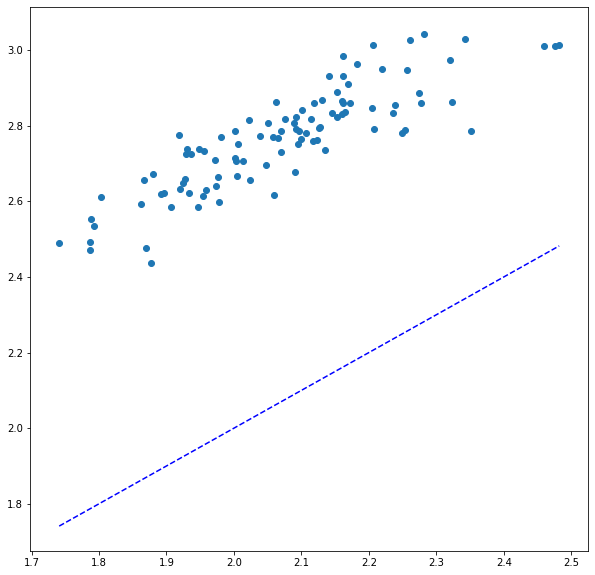

In [66]:
x_min = np.min(outputs[:,0])
x_max = np.max(outputs[:,0])

plt.scatter(outputs[:,0],labels[:,0])
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")

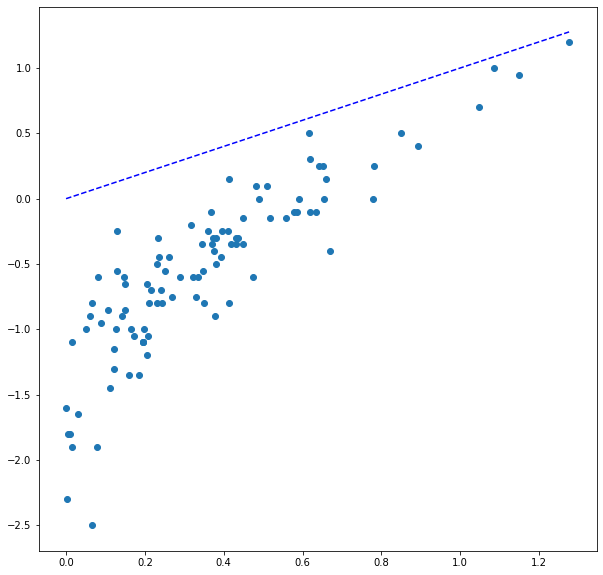

In [67]:
x_min = np.min(outputs[:,1])
x_max = np.max(outputs[:,1])

plt.scatter(outputs[:,1],labels[:,1])
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")